# Soft Computing

## Vežba 2 - Semantička segmentacija


Segmentacija slike je proces deljenja slike na više različitih regiona (segmenata). Doprinosi lakšoj analizi i razumevanju slika. Najčešće se koristi za izdvajanje objekata ili granica između objekata na slikama. Segmentacija u stvari predstavlja proces dodeljivanja određene labele svakom pikselu na slici, tako da pikseli koji imaju istu vrednost dele iste karakteristike (ili pripadaju istom objektu). Pronalazi višestruku upotrebu u medicini, autonomnoj vožnji, video nadzoru, itd.

Na prethodnom terminu smo radili neke osnovne operacije za obradu slike. Upotrebom samo tih operacija za izdvajanje regiona od interesa ne bismo mogli dobiti željene rezultate za konture koje imaju malo dodirnih tačaka.

## Watershed

Česta operacija koja se koristi kada nam same boje ne nose mnogo informacija je konvertovanje iz RGB modela u nijanse sivih (grayscale). Na ovaj način se gubi informacija o boji piksela na slici, ali sama slika postaje mnogo lakša za dalju obradu. Svaka grayscale slika može biti posmatrana kao topografska površina gde pikseli visokog intenziteta označavaju vrhove i brda, dok se oni niskog intenziteta odnose na doline. 

<img src="images/watershed-flooding-graph.png" width="400">

Svaku izolovanu dolinu (lokalni minimum) punimo različitom bojom (labele). Kako se nivo vode povećava, u zavisnosti od vrhova (gradijenata) koji su u blizini, voda iz različitih dolina (i različitih boja) će početi da se spaja. Kako bismo ovo izbegli, na mestima gde se voda spaja počinjemo da gradimo barijere. Postupak punjenja vode i izgradnje barijera se ponavlja sve dok svi vrhovi ne budu pod vodom. Na osnovu kreiranih barijera dobijamo segmentiranu sliku. 

Primena algoritma na ovaj način može dovesti do prekomerne segmentacije, posebno za slike koje u sebi sadrže šum i veliki broj lokalnih minimuma. Unapređenje algoritma koje predstavlja plavljenje topografske površine iz prethodno definisanog skupa markera sprečava prekomernu segmentaciju. Detaljnije objašnjenje je dostupno [ovde](https://people.cmm.minesparis.psl.eu/users/beucher/wtshed.html). 

[OpenCV biblioteka](https://docs.opencv.org/4.4.0/d7/d1b/group__imgproc__misc.html#ga3267243e4d3f95165d55a618c65ac6e1) sadrži implementaciju marker-based watershed algoritma za koji je potrebno da sami odredimo koje doline će se spojiti, a koje ne:

```code
markers	= cv.watershed(image, markers)
```

Parametar *image* predstavlja RGB sliku čije su vrednosti piksela predstavljene u realnom intervalu (float32).
Parametar *markers* reprezentuje sliku istih dimenzija kao *image* koja sadrži sledeće oznake:
1. poznati objekti su označeni različitim oznakama (label)
2. delovi za koje smo sigurni da pripadaju pozadini (background) su označeni drugom bojom 
3. delovi za koje nismo sigurni da li pripadaju pozadini (background) ili su deo nekog objekta (foreground) su označeni sa 0.

Izlaz predstavlja slika koja je dobijena tako što je ulazna slika *markers* ažurirana tako što su granice između objekata postavljene na vrednost -1.

In [7]:
import numpy as np
import cv2 # OpenCV
import matplotlib
from matplotlib import pyplot as plt

In [9]:
# iscrtavanje slika u notebook-u
%matplotlib inline
# prikaz vecih slika
matplotlib.rcParams['figure.figsize'] = 16,12

Sledeće metode su detaljno objašnjene na prethodnim vežbama.

In [5]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret, image_bin = cv2.threshold(image_gs, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return image_bin

def invert(image):
    return 255-image

def display_image(image, color=False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')

Za početak, učitavamo sliku.

In [11]:
img = load_image("images/water_coins.jpg")
display_image(img, color=True)

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


Učitanu sliku transformišemo u binarni oblik i primenjujemo morfološke operacije kako bismo uklonili šum.

In [10]:
img_bin = image_bin(image_gray(img))
# uklanjanje suma
kernel = np.ones((3,3), np.uint8) # strukturni element 3x3 blok
opening = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel, iterations = 2) # otvaranje
display_image(opening)

NameError: name 'img' is not defined

Sve piksele delimo u tri grupe:
1. one koji pripadaju pozadini (background)
2. one koji pripadaju objektima (foreground) 
3. ostale

Primenom dilacije povećavamo površinu objekata na slici tako da sa sigurnošću znamo da sve ono što predstavlja pozadinu rezultujuće slike, sigurno jeste pozadina. 

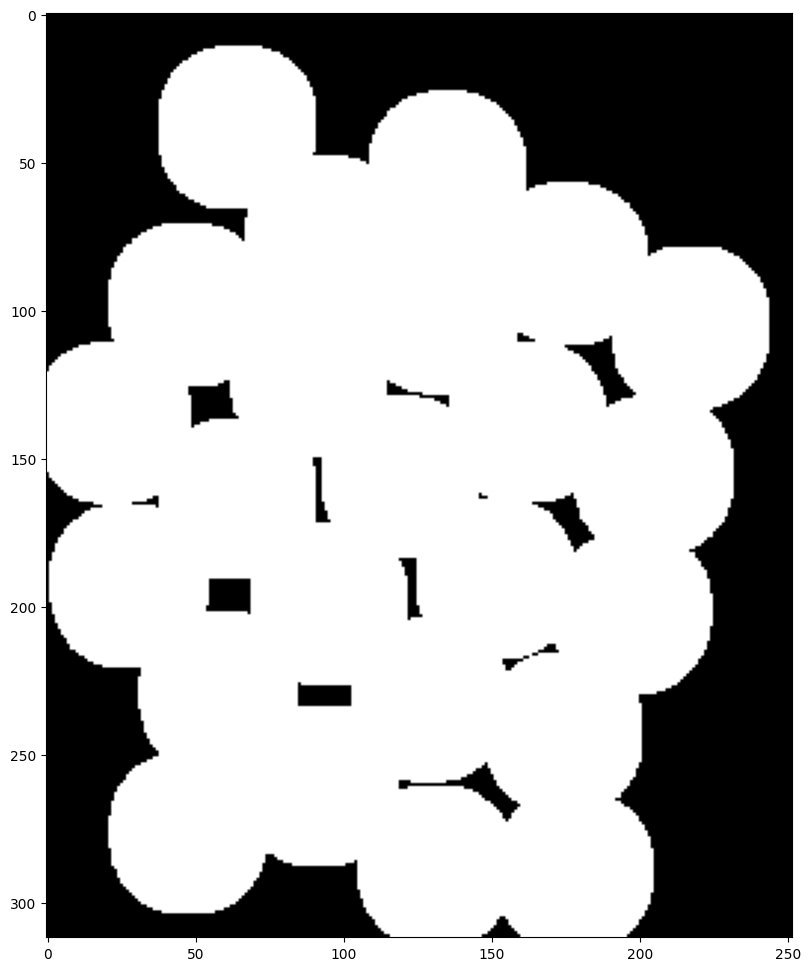

In [6]:
# izdvajanje regiona koji sigurno pripadaju pozadini (background)
sure_bg = cv2.dilate(opening, kernel, iterations=3)
display_image(sure_bg)

Pošto se objekti dodiruju, za izdvajanje piksela koji sigurno pripadaju novčićima koristimo [distanceTransform](https://docs.opencv.org/4.4.0/d7/d1b/group__imgproc__misc.html#ga8a0b7fdfcb7a13dde018988ba3a43042) metodu uz primenu odgovarajućeg praga. Metoda distanceTransform za svaki piksel (binarne) ulazne slike računa udaljenost od najbližeg piksela koji ima vrednost 0. Izlaz predstavlja slika sa izračunatim udaljenostima za svaki piksel, istih dimenzija kao ulazna slika.

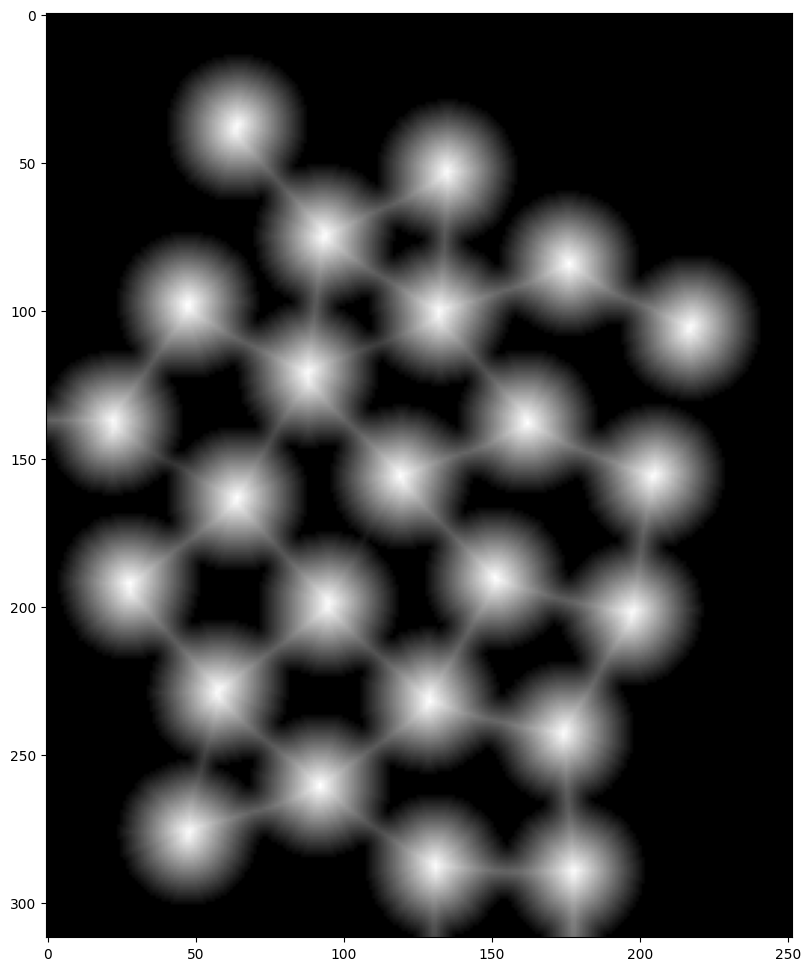

In [7]:
# izdvajanje regiona koji pripadaju objektima (foreground)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5) #  DIST_L2 - Euklidsko rastojanje
display_image(dist_transform)

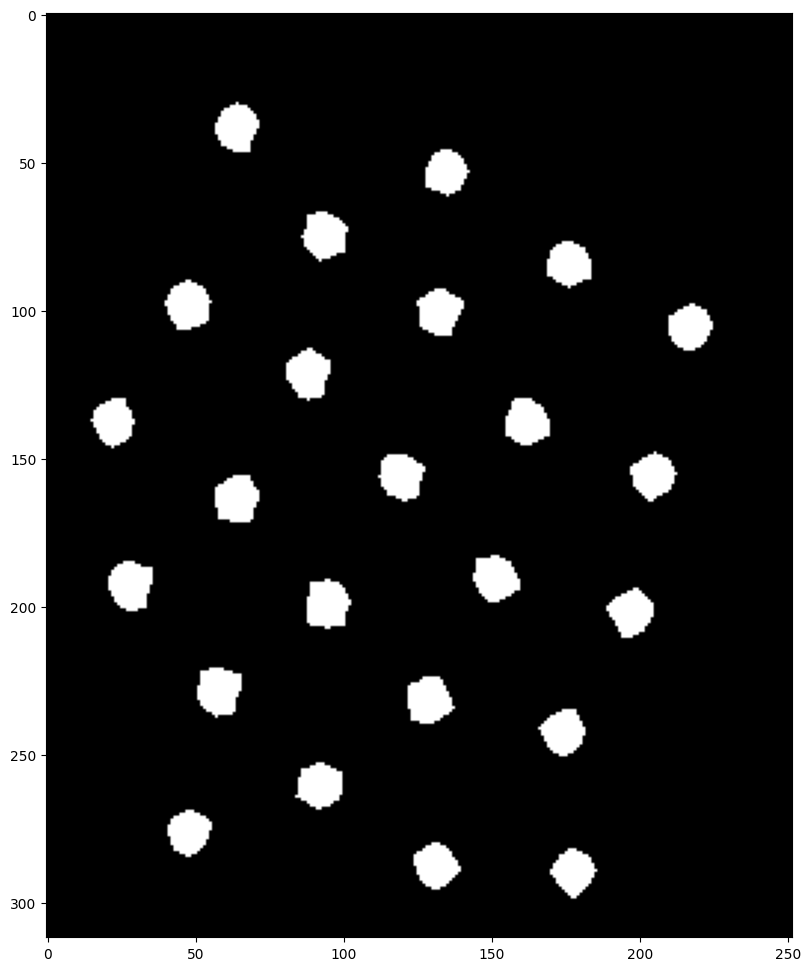

In [8]:
# za prag uzimamo 70 percentil najudaljenijih piksela 
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0) 
display_image(sure_fg)

Delove za koje nismo sigurni da li pripadaju pozadini ili objektu dobijamo oduzimanjem ove dve slike.

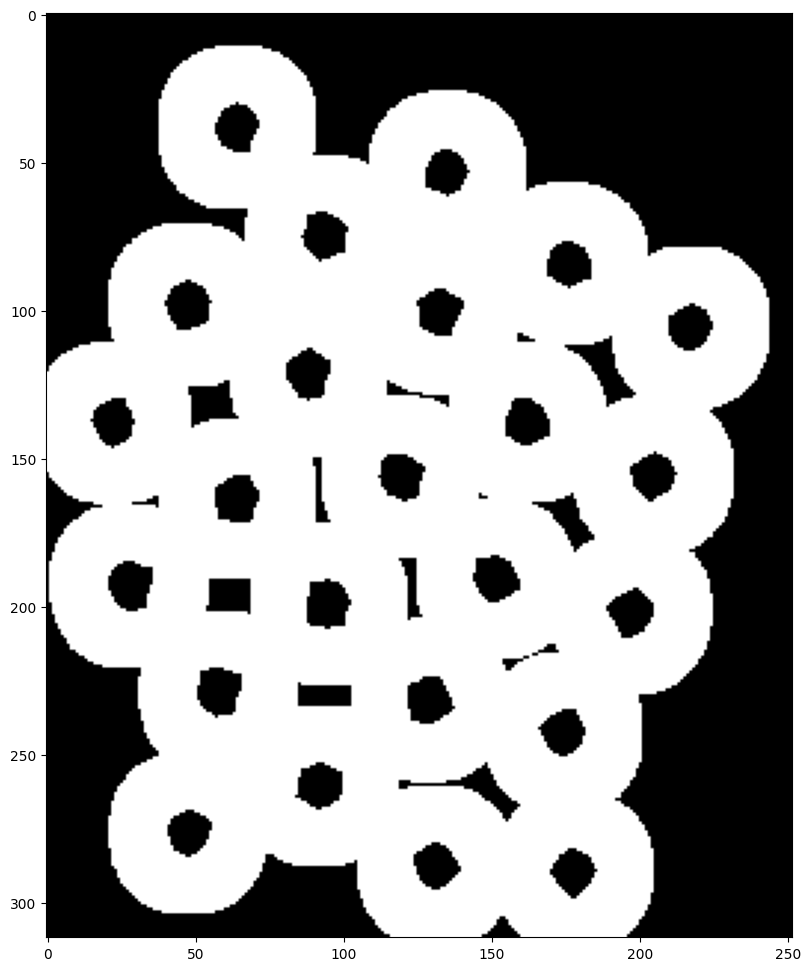

In [9]:
# izdvajanje ostalih delova za koje ne znamo da li predstavljaju background ili foreground
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
display_image(unknown)

### Kreiranje markera

Regione za koje znamo da pripadaju ili pozadini ili objektima označavamo bilo kojim pozitivnim (različitim) celim brojevima, dok nepoznatim regionima pridružujemo vrednost 0. 

OpenCV ima metodu **cv.connectedComponents()** koja pozadinu slike označava sa 0, a ostali brojevi se označavaju celim brojevima počev od 1.

In [10]:
# marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# svim vrednostima dodajemo 1 kako pozadina ne bi imala vrednost 0 (ona je rezervisana za nepoznate regione)
markers = markers+1
# oznacavanje nepoznatih regiona sa 0
markers[unknown==255] = 0

Prikaz rezultata pomocu JET mape boja. Tamnoplava boja odgovara nepoznatim regionima.

In [80]:
def label2rgb(image):
    cmap = plt.get_cmap('jet', len(np.unique(markers)))
    return cmap(markers)

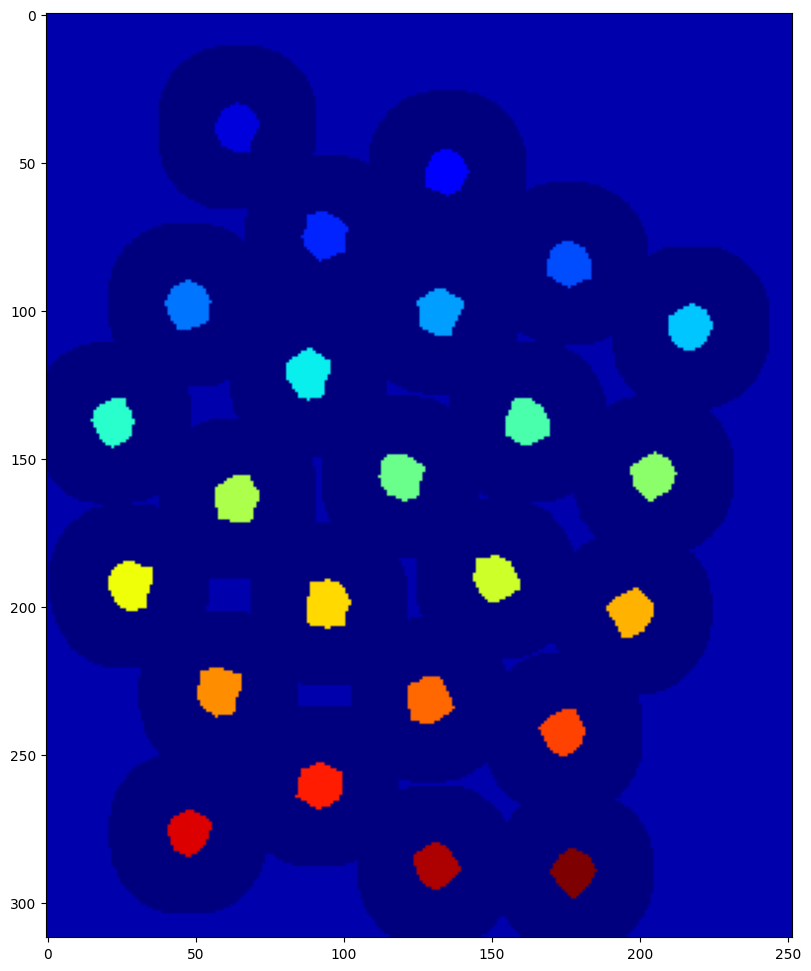

In [12]:
rgba_img = label2rgb(markers)
display_image(rgba_img, color=True)

Sada, sa ovako pripremljenim markerima, možemo primeniti watershed algoritam koji modifikuje ulaznu sliku markera tako što ivice između objekata označava sa -1. 

In [13]:
markers = cv2.watershed(img, markers)
img[markers == -1] = [255, 0, 0]

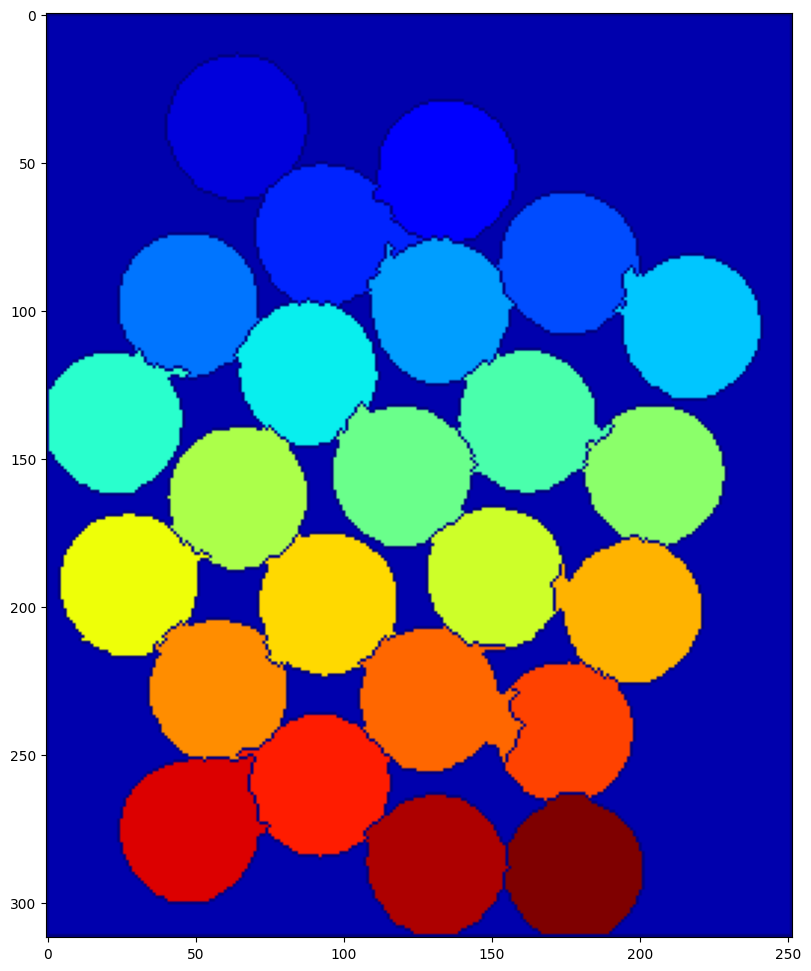

In [14]:
rgba_img = label2rgb(markers)
display_image(rgba_img, color=True)

Na sledeći način možemo dobiti broj detektovanih objekata (u ovom slučaju, novčića):

In [ ]:
# markers je lista listi, gde je za svaki elemenat "unutrasnjih" listi boja piksela na slici
print(markers)

In [15]:
# ovom linijom koda dobijamo sve unikatne vrednosti boja u svim "unutrasnjim" listama
unique_colours = {x for l in markers for x in l}
print(unique_colours)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, -1}


In [16]:
# -1 nam se odnosi na granice među objektima, ovu boju nećemo računati
# jedan od ovih brojeva se odnosi na pozadinsku boju, pa zbog toga ne računamo još jednu boju
# znači, ukupno treba da oduzmemo 2 boje od svih prisutnih, kako bismo dobili koliko je prisutno unikatnih boja,
# odnosno detektovanih objekata
number_of_coins = len(unique_colours) - 2
print("Broj detektovanih novčića:", number_of_coins)

Broj detektovanih novčića: 24


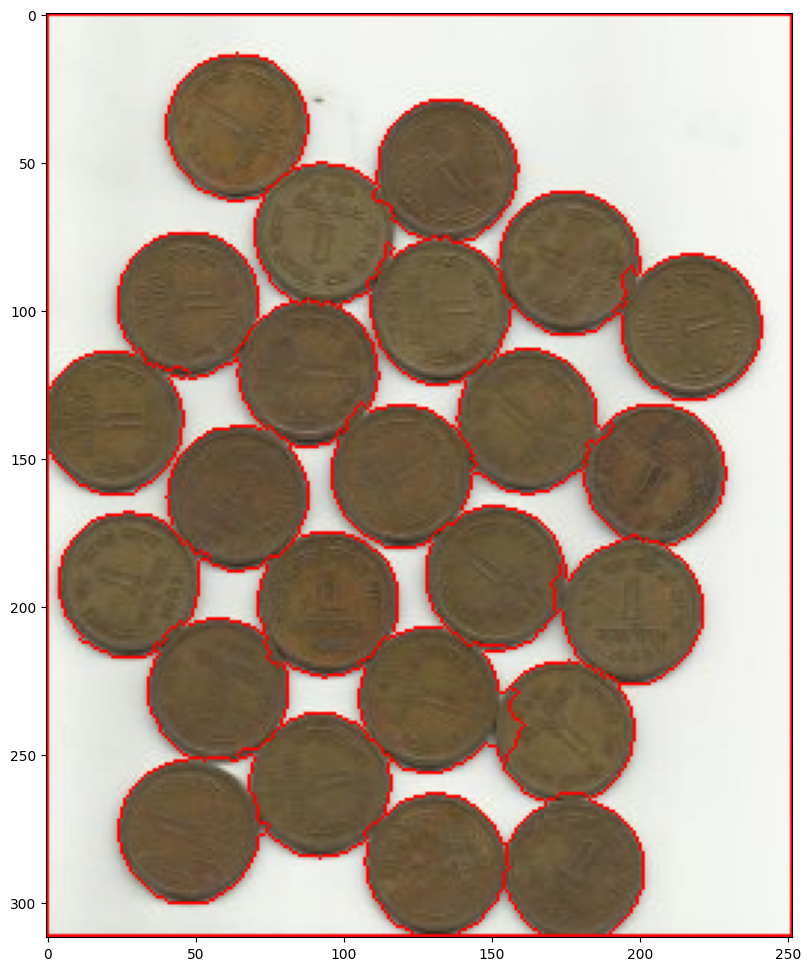

In [17]:
display_image(img, color=True)

## K-means

### Podsećanje

K-means je model nenadgledanog mašinskog učenja koji se koristi za grupisanje podataka u K različitih grupa.

<img src="images/kmeans.gif"/>

U OpenCV postoji implementirana metoda [kmeans](https://docs.opencv.org/4.4.0/d5/d38/group__core__cluster.html#ga9a34dc06c6ec9460e90860f15bcd2f88) koja ima sledeće ulazne parametre:
* **samples** - uzorci na osnovu kojih će se vršiti klasterovanje, podaci moraju biti u obliku matrice ***koja sadrži np.float32 vrednosti gde svaka kolona predstavlja jedno obeležje (feature)***
* **K** - broj klastera
* **bestLabels** - parametar koji predstavlja i izlaz, niz celih brojeva koji čuvaju vrednost indeksa centra za svaki uzorak
* **criteria** - kriterijum zaustavljanja, maksimalan broj iteracija ili željena tačnost
* **attempts** - broj ponavljanja algoritma sa različitom inicijalizacijom početnih oznaka
* **flags** - oznaka koja može imati jednu od vrednosti: KMEANS_RANDOM_CENTERS, KMEANS_PP_CENTERS, KMEANS_USE_INITIAL_LABELS 

Kao izlaz vraća tri vrednosti: kompaktnost (zbir kvadratnog rastojanja svake tačke od odgovarajućeg klastera), niz oznaka za svaki piksel i centre klastera.

### Početak implementacije

Za početak, učitavamo sliku.

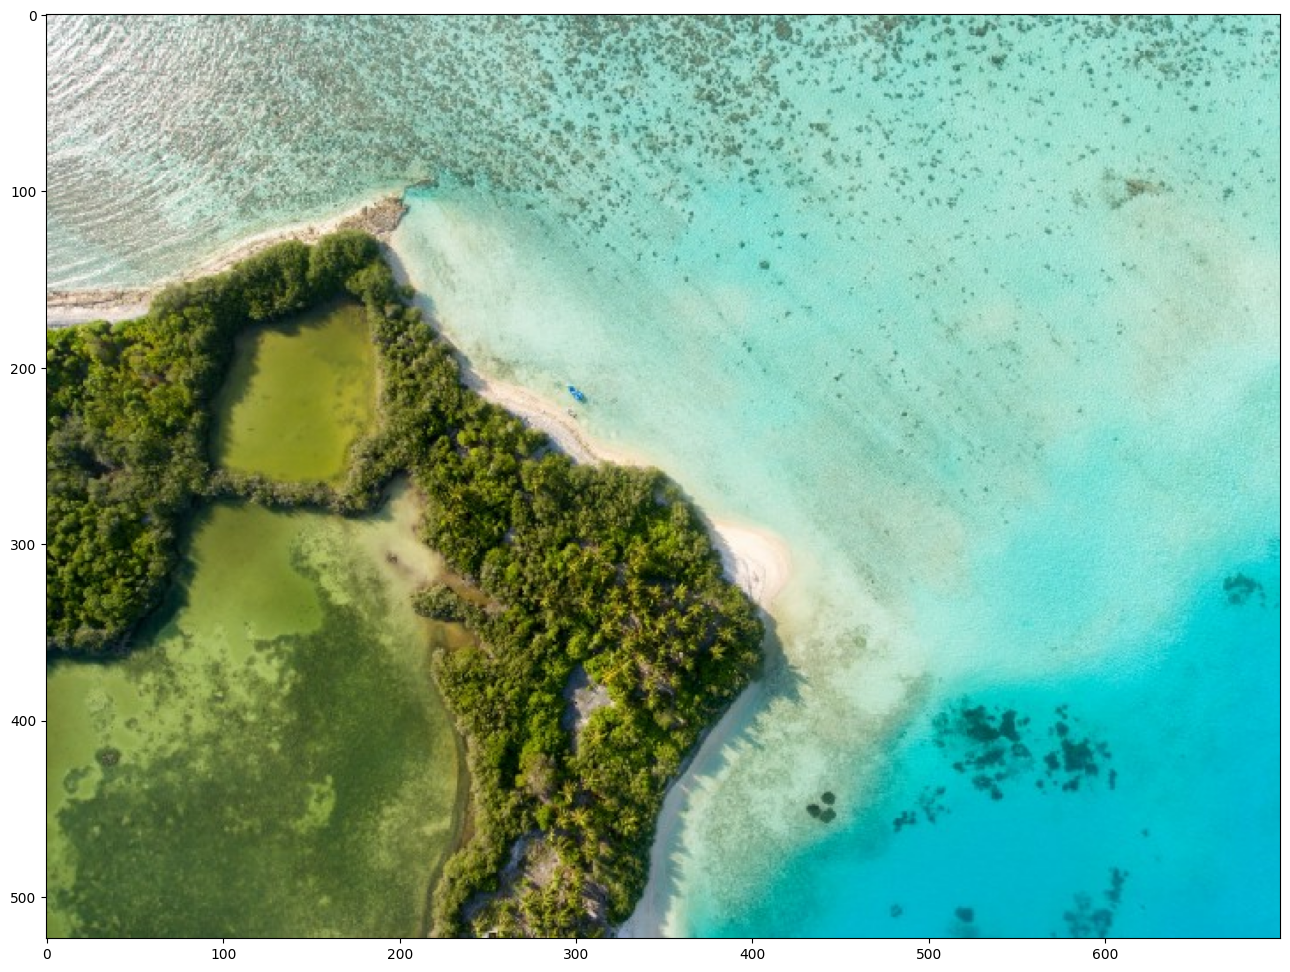

In [205]:
image = load_image('images/beach.jpeg')
display_image(image, color=True)

Kako *kmeans* na ulazu zahteva matricu *float32* vrednosti u kojoj svaka kolona predstavlja jedno obeležje, moramo sliku prebaciti u željeni oblik. Slika u boji ima tri obeležja: R, G i B, što znači da je moramo prebaciti u niz veličine Mx3, gde M predstavlja ukupan broj piksela. 

In [206]:
# sliku konvertujemo u 2D niz piksela sa po 3 vrednosti (RGB)
pixel_values = image.reshape((-1,3)) 
# konvertujemo sve u float32
pixel_values = np.float32(pixel_values)
print(pixel_values.shape)

(366800, 3)


Definišemo kriterijum zaustavljanja i broj klastera K i pozivamo metodu. 

Kriterijum zaustavljanja predstavlja tuple od 3 vrednosti (type, max_iter, epsilon). Tip zaustavljanja može uzeti jednu od tri vrednosti:
* cv.TERM_CRITERIA_EPS - algoritam se zaustavlja ako je postignuta određena tačnost, epsilon
* cv.TERM_CRITERIA_MAX_ITER - algoritam se zaustavlja nakon određenog broja iteracija, max_iter
* cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER - algoritam se zaustavlja nakon što je ispunjen bilo koji od navedenih uslova

In [219]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 2
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

Nakon klasterovanja, svakom pikselu pridružujemo vrednost centra klastera kojem pripada, a potom sliku vraćamo u originalni oblik.

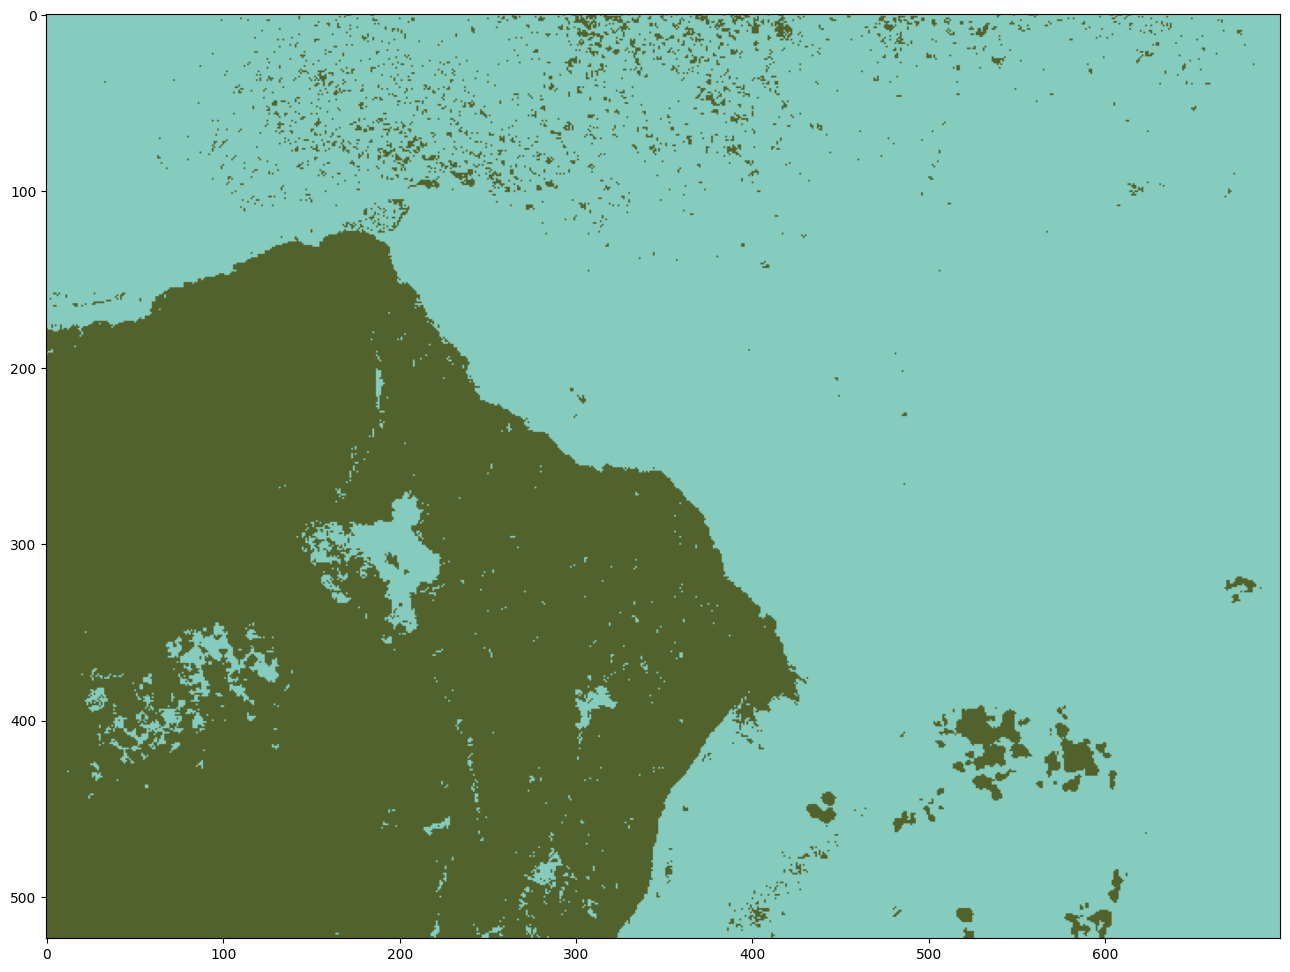

In [220]:
# konvertujemo vrednosti u 8-bitne
centers = np.uint8(centers)
# mapiramo sve piksele na boju koja odgovara centru klastera
segmented_data = centers[labels.flatten()]
# vraćamo u dimenzije slike
segmented_image = segmented_data.reshape((image.shape))
display_image(segmented_image, color=True)

Kako bismo utvrdili koji klaster se odnosi na koji deo, možemo te piksele prikazati u crnoj boji.

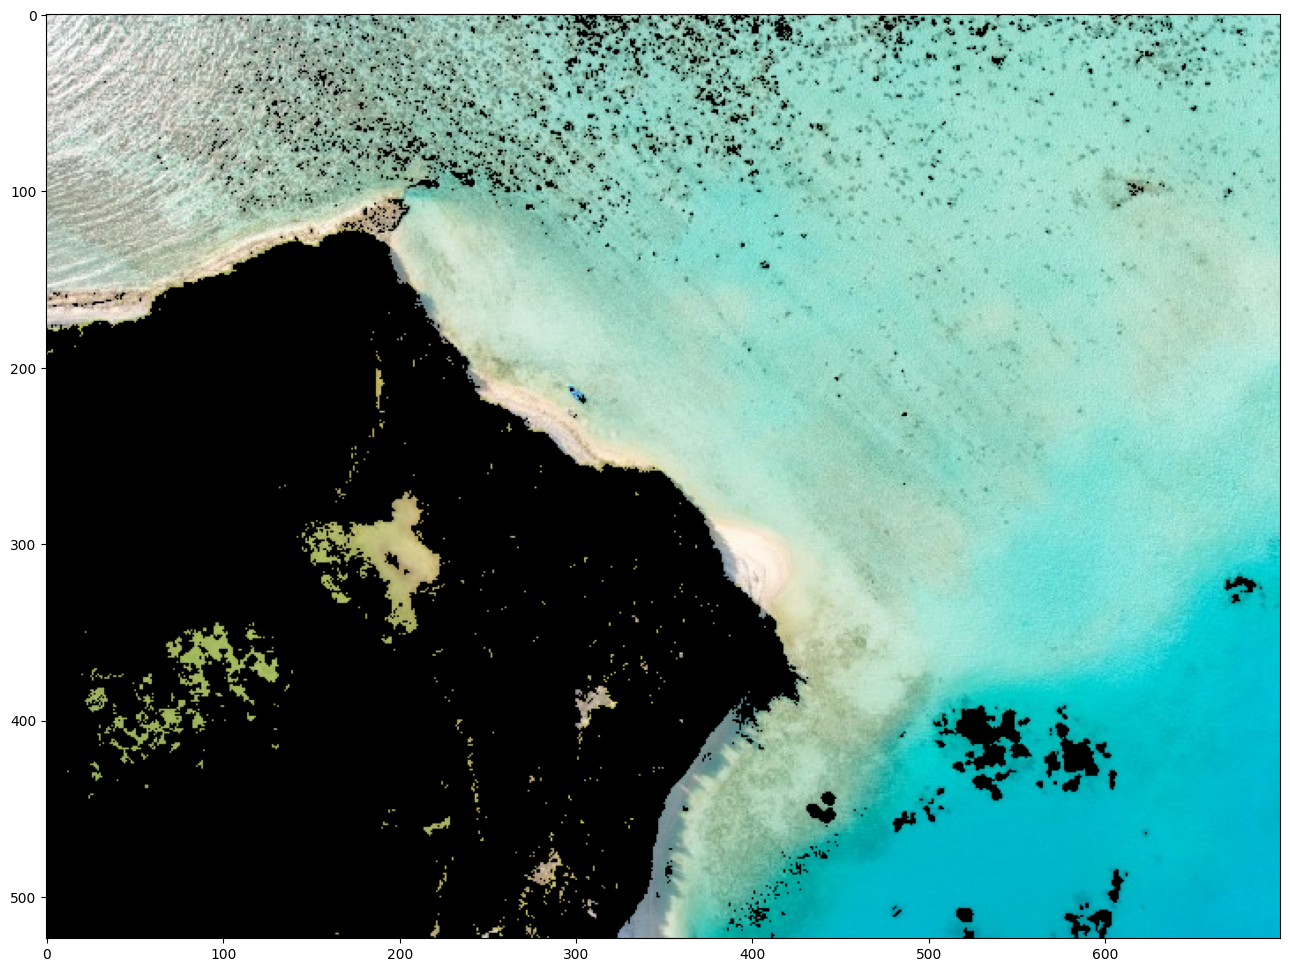

In [221]:
# piksele klastera označenim brojem 2 pretvaramo u crne
masked_image = np.copy(image)
# sliku konvertujemo u vektor piksela dimenzija Mx3
masked_image = masked_image.reshape((-1, 3))
# biramo koji klaster želimo da izdvojimo
cluster = 0
labels = labels.flatten()
masked_image[labels == 1] = [0, 0, 0]

# vraćamo sliku u početni oblik
masked_image = masked_image.reshape(image.shape)
display_image(masked_image)

## Zadaci

1. Na slici sa novčićima (**images/coins.jpg**), prebrojati koliko ima novčića

2. Na slici sa crvenim krvnim zrncima (**images/bloodcells.jpg**), prebrojati koliko ima crvenih krvnih zrnaca.

3. Na slici sa tabletama (**images/tablets.jpg**) prebrojati koliko ima tableta

4. Na slike sa kafom (**images/coffee.gif**) prebrojati koliko ima zrna kafe.    

5. Na slici sa kruškama (**images/pears.png**) prebrojati koliko ima krušaka.  

6. Sa slike plaže (**images/beach.jpeg**) izdvojiti more

7. Sa slike gde se nalazi konj (**images/horse.jpg**) izdvojiti konja i livadu


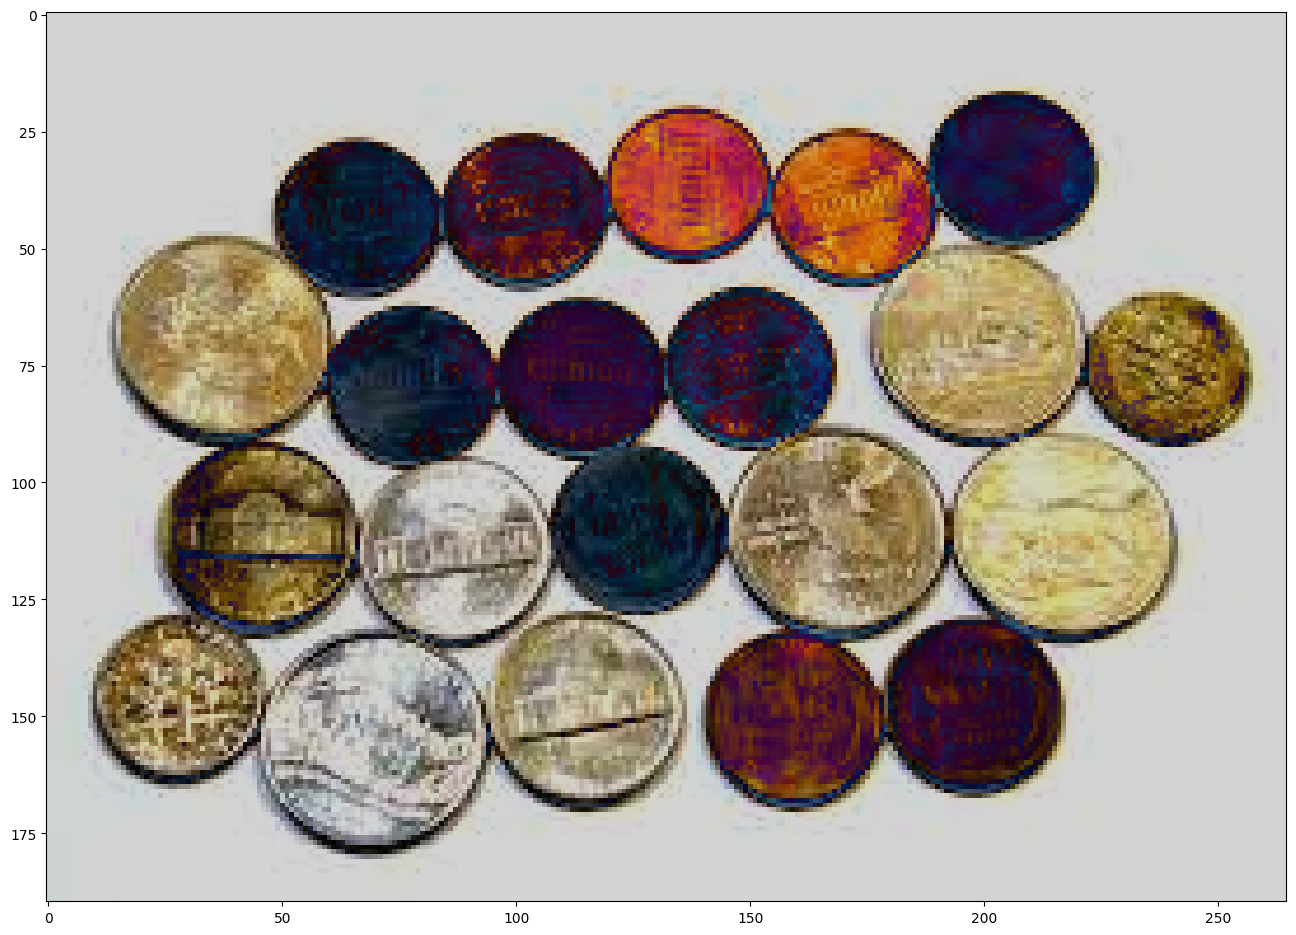

In [142]:
coins = load_image('images/coins.jpg')
coins = cv2.convertScaleAbs(coins, alpha=1.3, beta=-120)
display_image(coins)

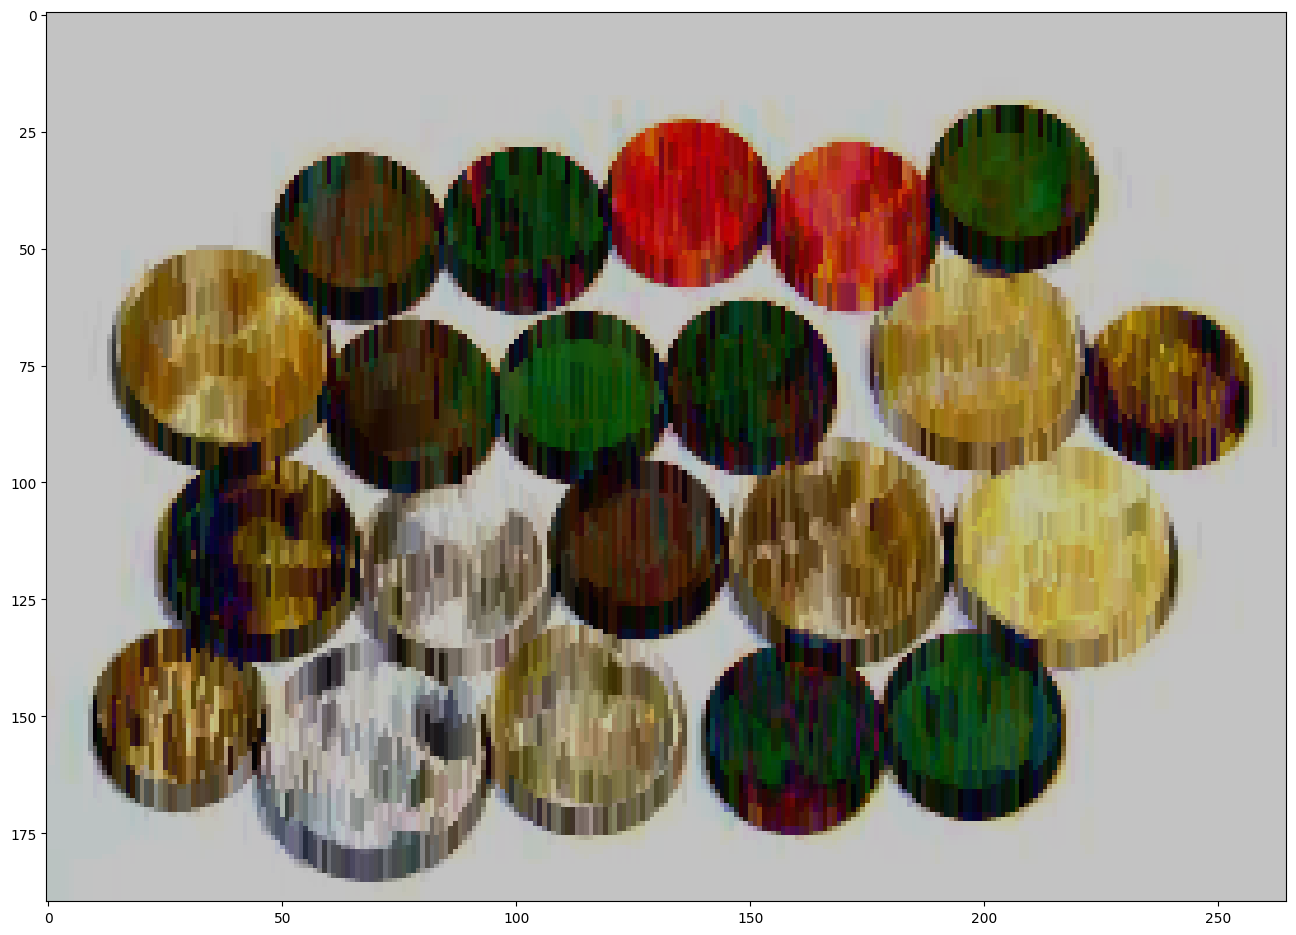

In [148]:
coins_beta = cv2.dilate(coins, (5, 5), iterations=3)
coins_beta = cv2.convertScaleAbs(coins_beta, alpha=1.4, beta=-100)
coins_beta = cv2.erode(coins_beta, (3, 3), iterations=5)
display_image(coins_beta)

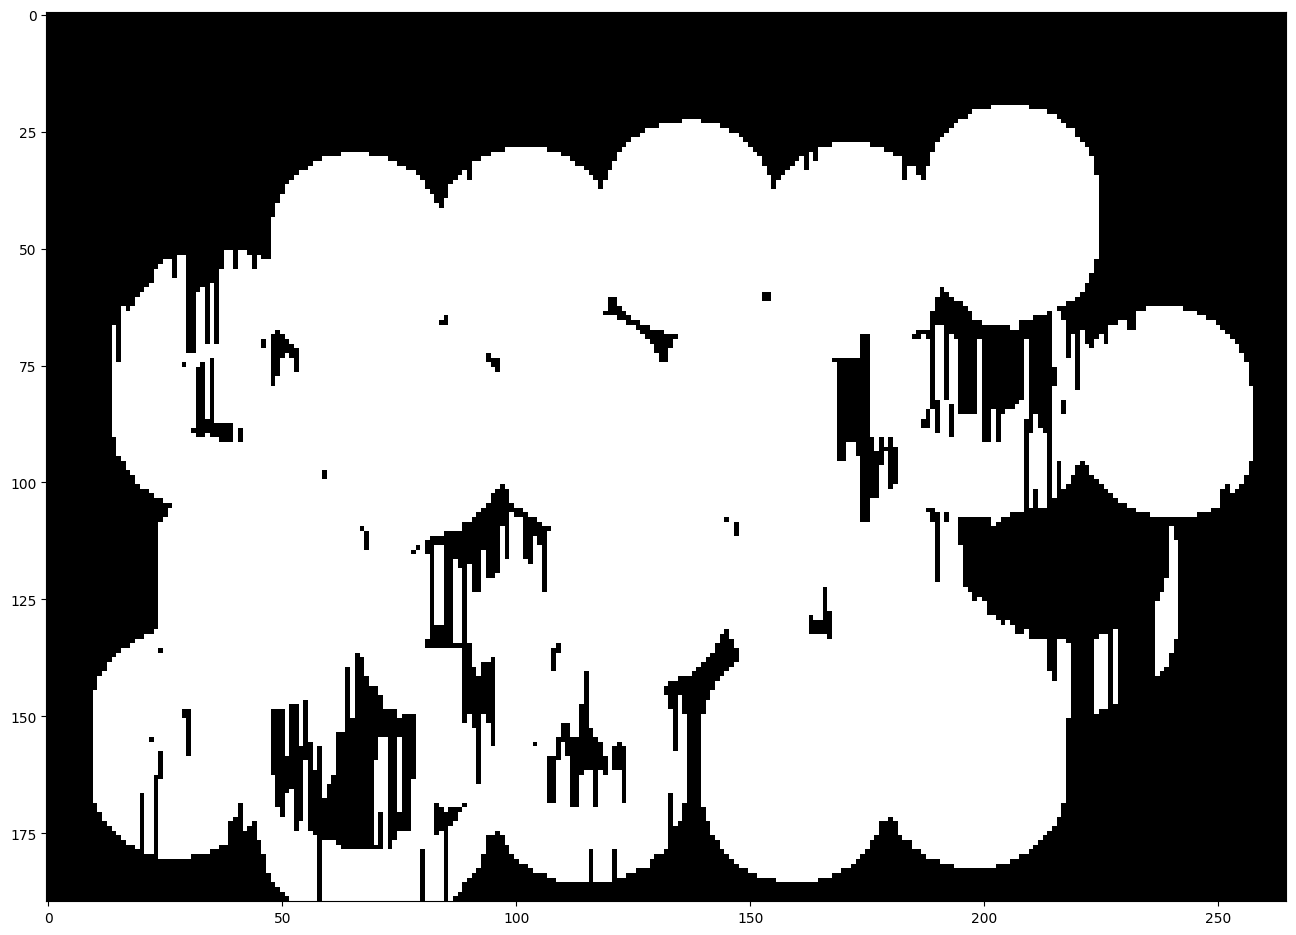

In [163]:
img_bin = image_bin(image_gray(coins_beta))
img_bin = cv2.dilate(img_bin, (5, 5), iterations=10)
plt.imshow(img_bin, 'gray')

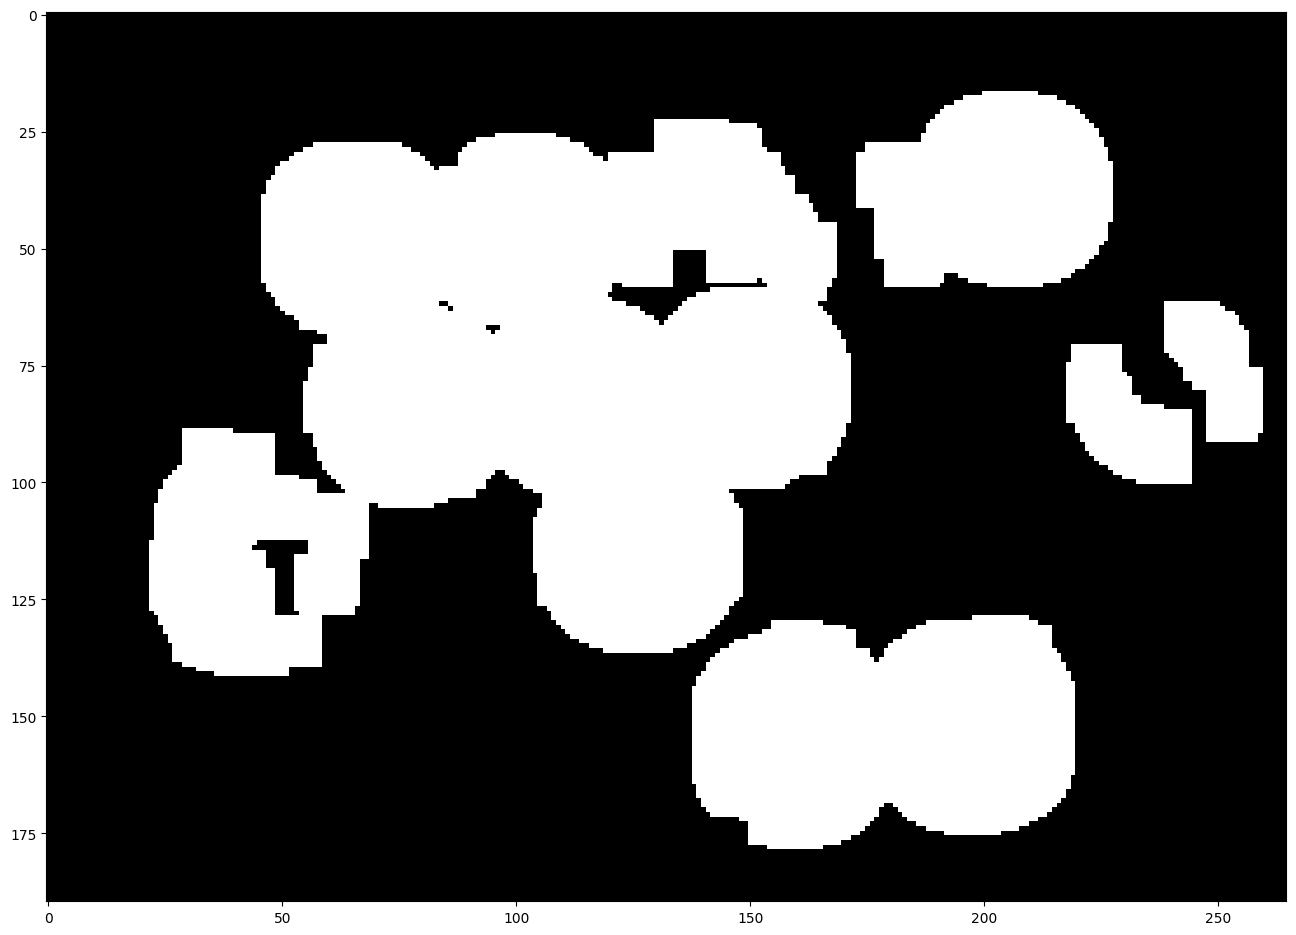

In [164]:
# izdvajanje regiona koji sigurno pripadaju pozadini (background)
sure_bg = cv2.dilate(opening, kernel, iterations=3)
display_image(sure_bg)

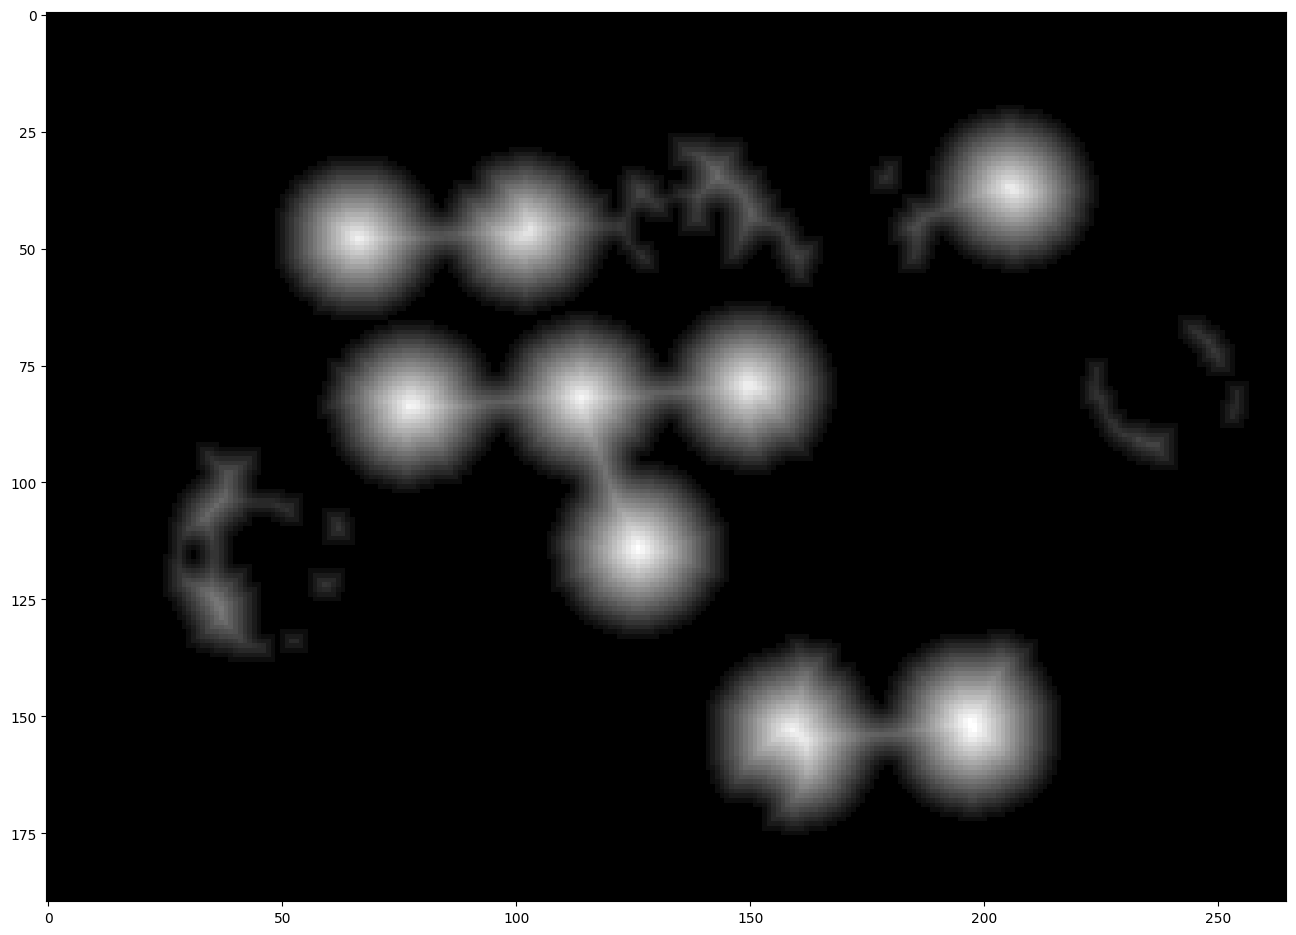

In [165]:
# izdvajanje regiona koji pripadaju objektima (foreground)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5) #  DIST_L2 - Euklidsko rastojanje
display_image(dist_transform)

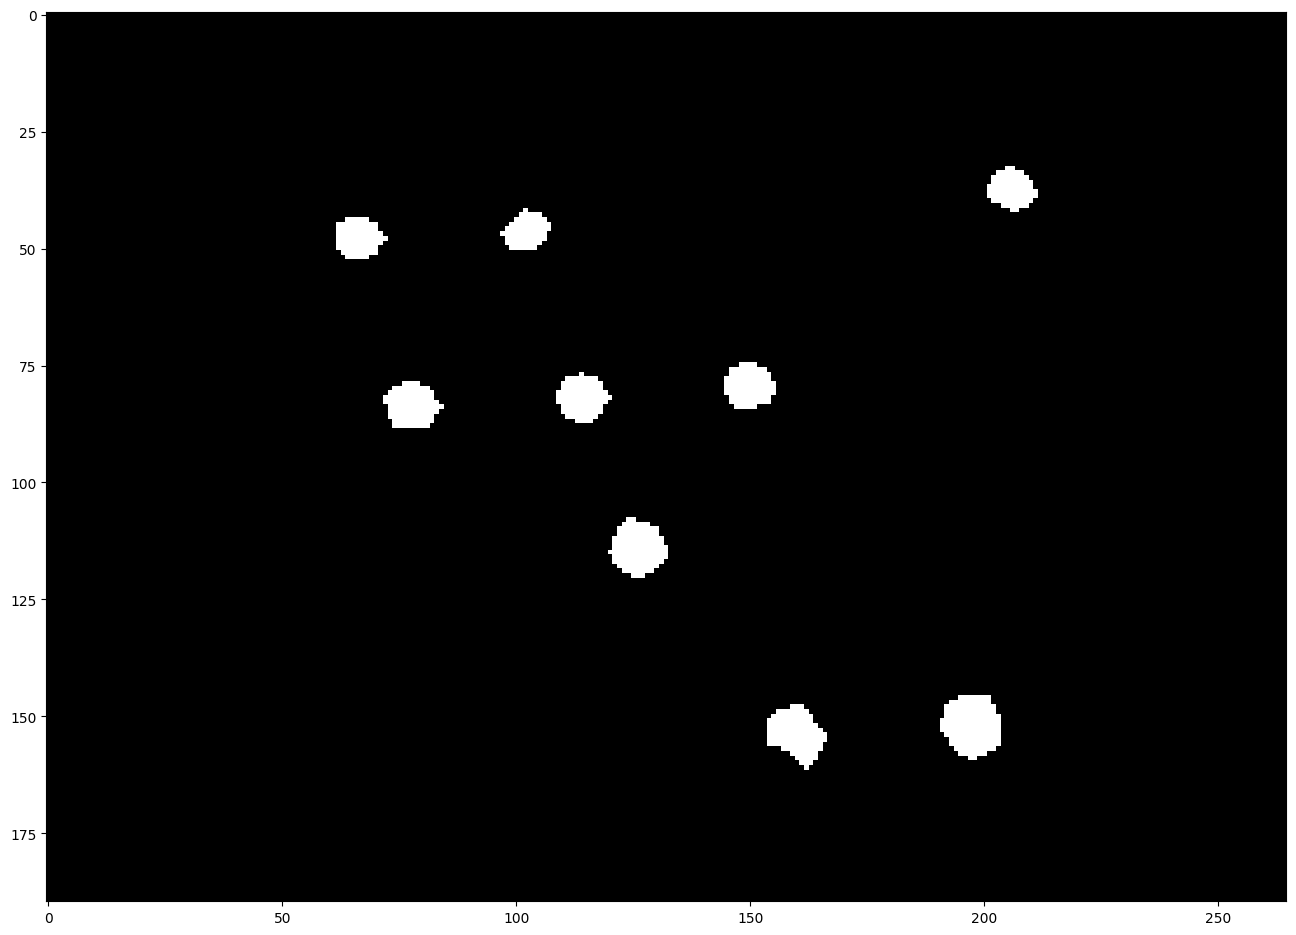

In [166]:
# za prag uzimamo 70 percentil najudaljenijih piksela 
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0) 
display_image(sure_fg)

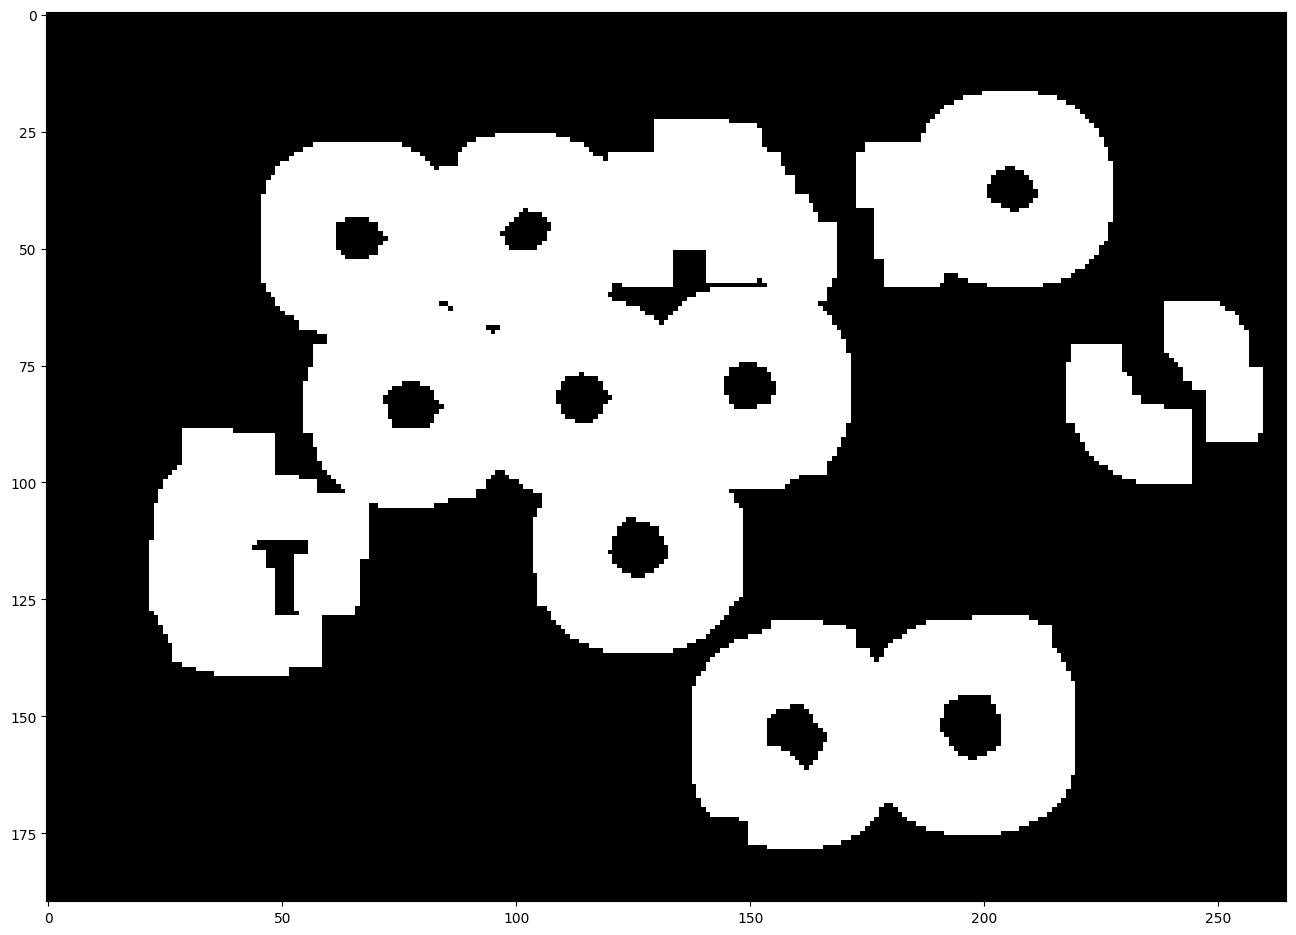

In [167]:
# izdvajanje ostalih delova za koje ne znamo da li predstavljaju background ili foreground
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
display_image(unknown)

In [168]:
# marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# svim vrednostima dodajemo 1 kako pozadina ne bi imala vrednost 0 (ona je rezervisana za nepoznate regione)
markers = markers+1
# oznacavanje nepoznatih regiona sa 0
markers[unknown==255] = 0

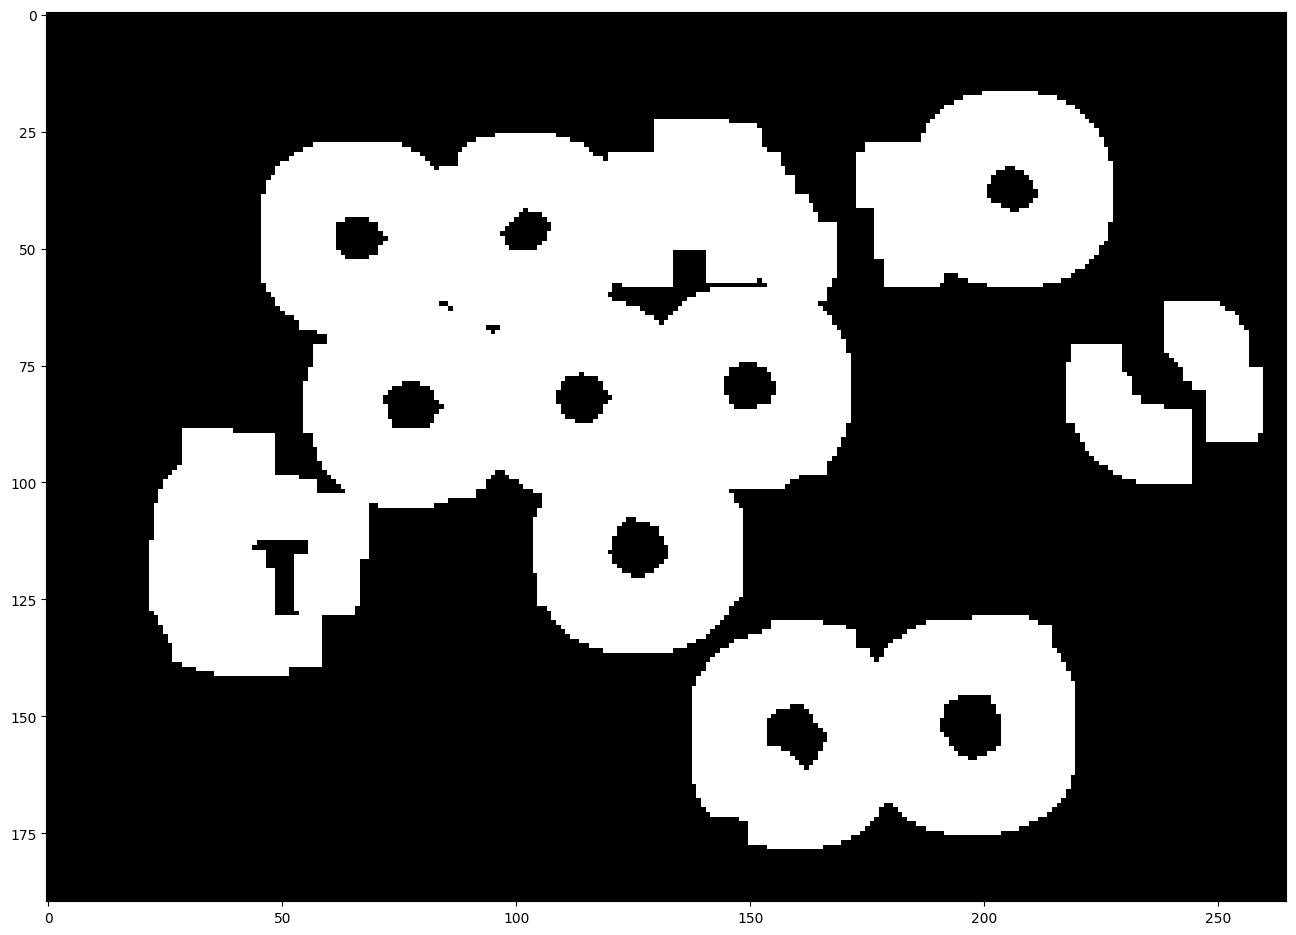

In [155]:
# izdvajanje ostalih delova za koje ne znamo da li predstavljaju background ili foreground
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
display_image(unknown)

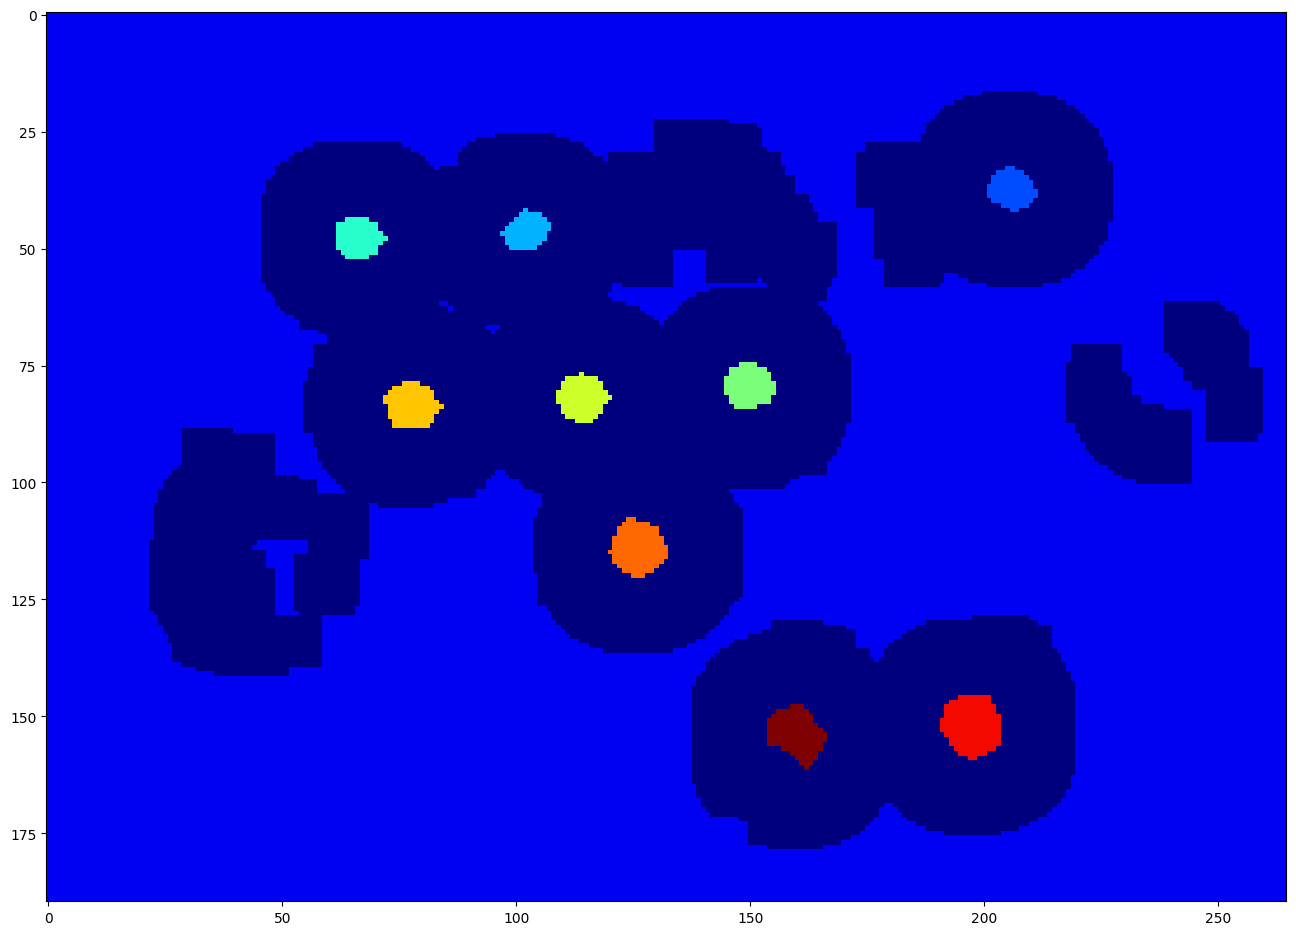

In [169]:
rgba_img = label2rgb(markers)
display_image(rgba_img, color=True)

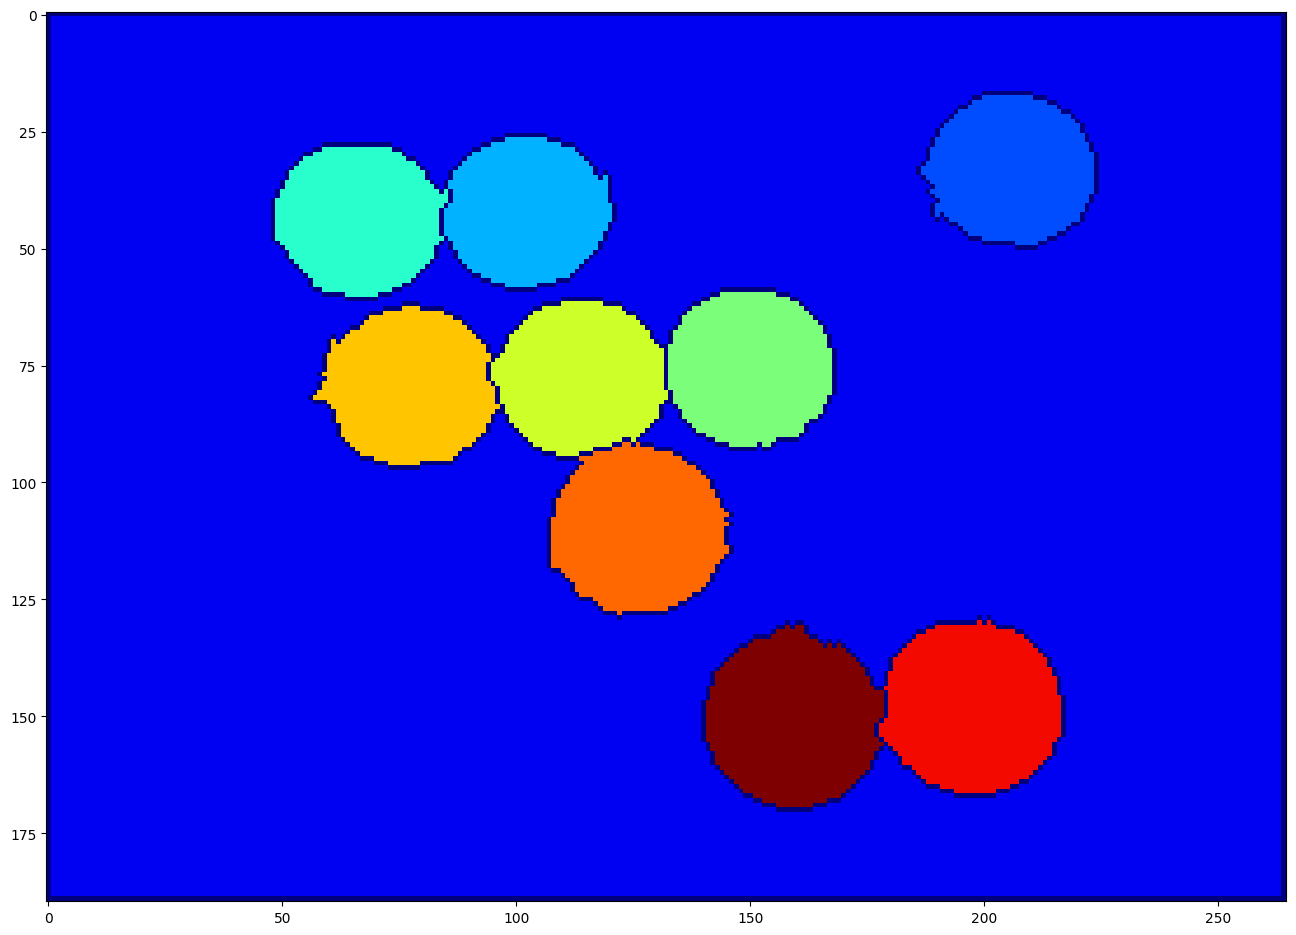

In [170]:
markers = cv2.watershed(coins, markers)
coins[markers == -1] = [255, 0, 0]
rgba_img = label2rgb(markers)
display_image(rgba_img, color=True)

In [171]:
# ovom linijom koda dobijamo sve unikatne vrednosti boja u svim "unutrasnjim" listama
unique_colours = {x for l in markers for x in l}
print(unique_colours)


{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1}


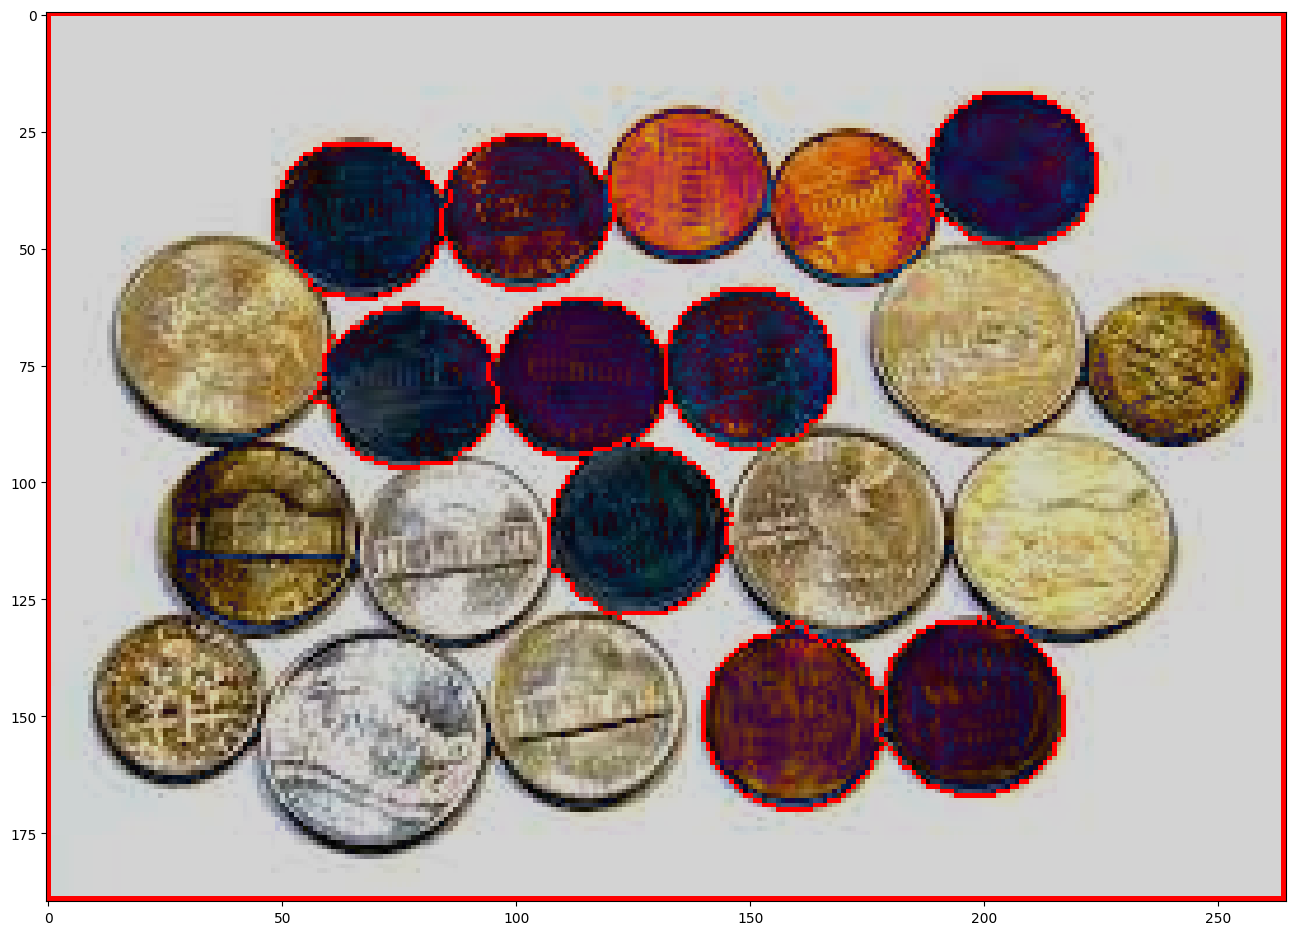

In [172]:
display_image(coins, color=True)

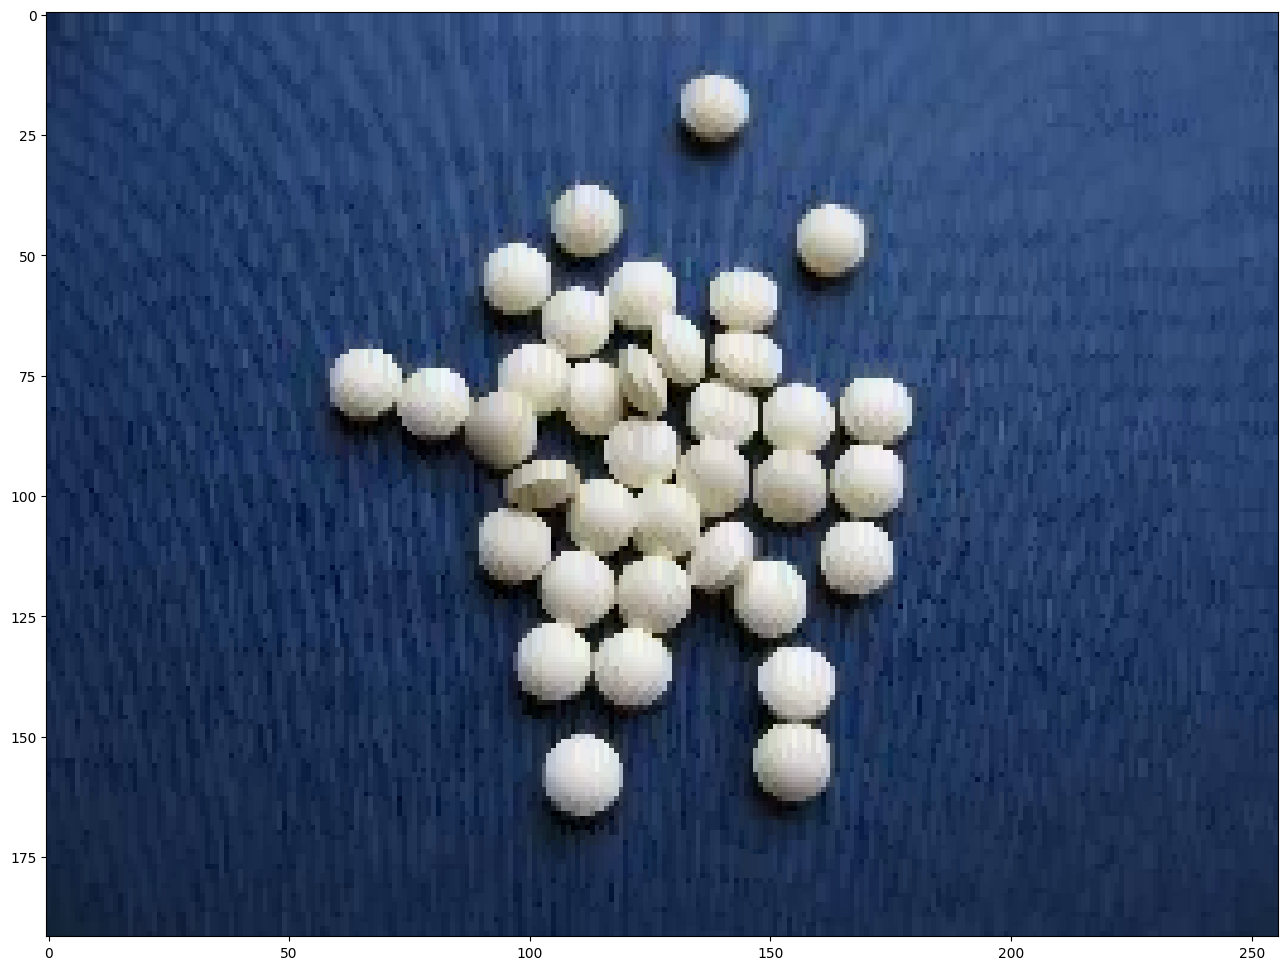

In [133]:
tablets = load_image('images/tablets.jpg')
tablets = cv2.erode(tablets, (3, 3), iterations=3)
tablets = cv2.dilate(tablets, (3, 3), iterations=3)

display_image(tablets)


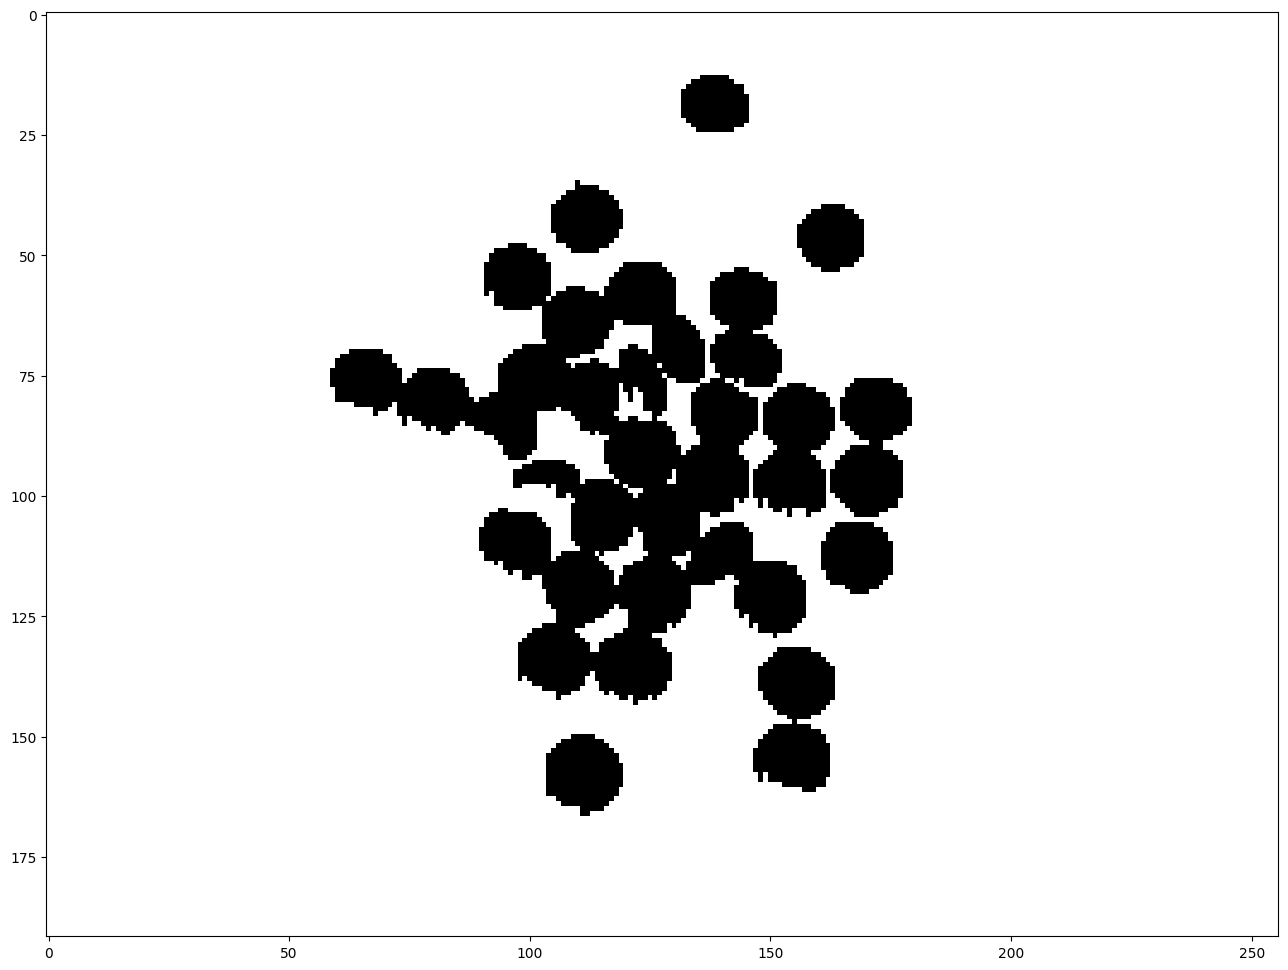

In [134]:
tablets_bin = image_bin(image_gray(tablets))
plt.imshow(tablets_bin, 'gray')

TypeError: Image data of dtype object cannot be converted to float

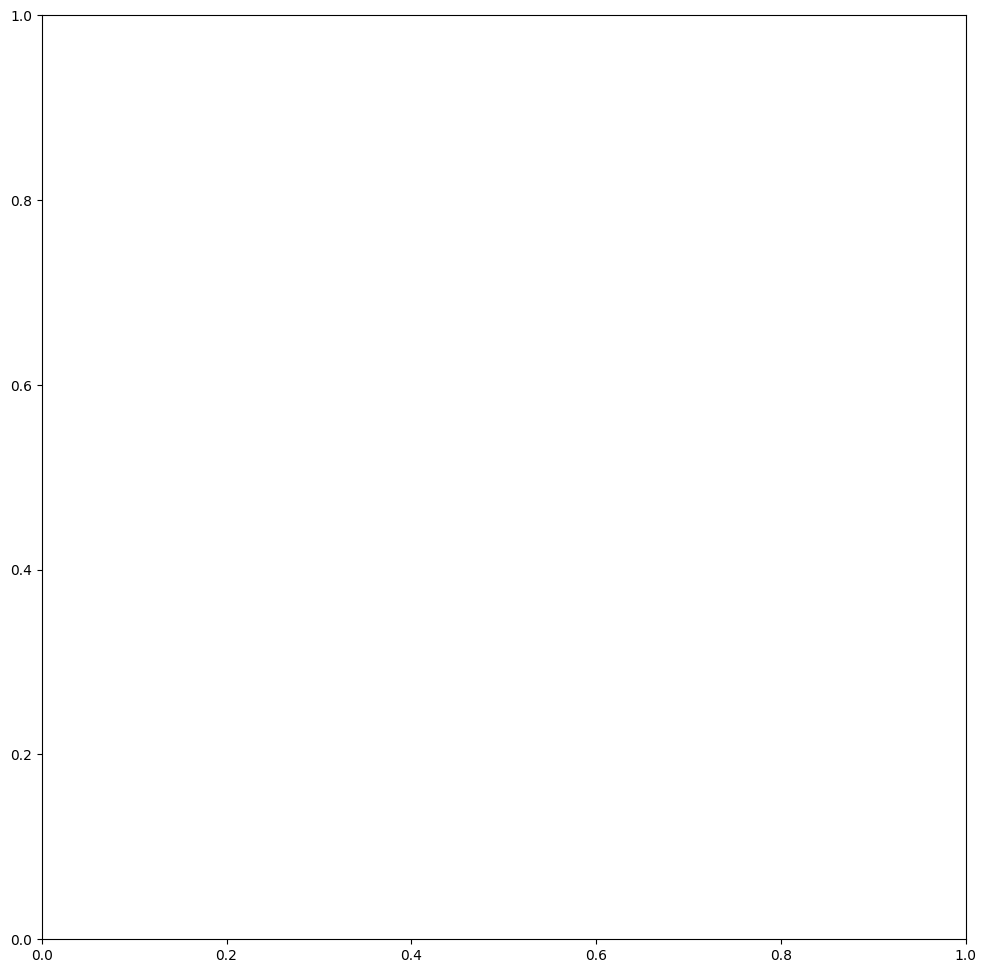

In [180]:
coffe = cv2.imread('images/coffee.gif', cv2.COLOR_)
plt.imshow(coffe)